## Data analysis

In [239]:
import re
import csv
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
import dateutil.parser
from sklearn import linear_model,ensemble, tree, model_selection


%matplotlib inline




In [845]:
with open('master.csv', 'r') as f:
    reader = csv.reader(f)
    df = list(reader)
df=pd.DataFrame(df)  
df.columns = df.iloc[0]
df = df[1:]

df.columns=['street address', 'city', 'state', 'zip', 'bed', 'bath', 'sqft', 'type',
       'year-built', 'heating', 'cooling', 'parking', 'lot', 'school1',
       'school2', 'school3', 'grade1', 'grade2', 'grade3', 'rate1', 'rate2',
       'rate3', 'sold-price', 'sold-date', 'url']


In [847]:
#drop duplicates
df.drop_duplicates(subset='street address', keep='last', inplace=True)

In [848]:
#change the school grades
df.replace(to_replace=['8-Jun','8-May','12-Jul','K-8'],value='middle',inplace=True)
df.replace(to_replace=['12-Sep'],value='high',inplace=True)
df.replace(to_replace=['K-5','K-4'],value='elementary',inplace=True)

In [849]:
df_school_rate=df.loc[:,['rate1','rate2','rate3','grade1','grade2','grade3']]
df_school_name=df.loc[:,['school1','school2','school3','grade1','grade2','grade3']]
#convert dataframe to a dictionary with keys=variable names, value=variable value
df_school_rate_dict=df_school_rate.to_dict(orient='records')
df_school_name_dict=df_school_name.to_dict(orient='records')


In [850]:
#function that turns original values of the dictionary to keys (elementary, middle, high), and values are rating or school name
def fix_rates(dictionary):
    lst=[]
    for i in dictionary:
        d={}
        d[i['grade1']]=i['rate1']
        d[i['grade2']]=i['rate2']
        d[i['grade3']]=i['rate3']
        lst.append(d)
    return lst

def fix_schools(dictionary):
    lst=[]
    for i in dictionary:
        d={}
        d[i['grade1']]=i['school1']
        d[i['grade2']]=i['school2']
        d[i['grade3']]=i['school3']
        lst.append(d)
    return lst
        

In [851]:
#append the columns to df
rate=pd.DataFrame(fix_rates(df_school_rate_dict))
df['elementary-rate']=list(rate['elementary'])
df['middle-rate']=list(rate['middle'])
df['high-rate']=list(rate['high'])

school=pd.DataFrame(fix_schools(df_school_name_dict))
df['elementary']=list(school['elementary'])
df['middle']=list(school['middle'])
df['high']=list(school['high'])


In [852]:
#convert sqft into integer
sqft=[]
for i in df.sqft:
    try:
        sqft.append(int(i.replace(',', '')))
    except ValueError:
        sqft.append(float('nan'))
df.sqft=sqft 

#convert bed and bath to int
bed=pd.to_numeric(df.bed, errors='coerce')
df.bed=bed
bath=pd.to_numeric(df.bath, errors='coerce')
df.bath=bath

#convert year-built to int
built=pd.to_numeric(df['year-built'], errors='coerce')
df['year-built']=built

#convert sold-price into int
sold=pd.to_numeric(df['sold-price'], errors='coerce')
df['sold-price']=sold

#convert schoolrate into int
rate1=pd.to_numeric(df['elementary-rate'], errors='coerce')
df['elementary-rate']=rate1
rate2=pd.to_numeric(df['middle-rate'], errors='coerce')
df['middle-rate']=rate2
rate3=pd.to_numeric(df['high-rate'], errors='coerce')
df['high-rate']=rate3


In [853]:
#convert lotsize to int
#get rid of the sqft
lot=[]
for i in df.lot:
    lot.append(i.split(' ')[0].replace(',', ''))
#change the houses with HOA payment to lotsize 0
for i in range(0,len(lot)):
    if '$' in lot[i]:
        lot[i]='0'
#convert acres into sqft
for i in range(0,len(lot)):
    if '.' in lot[i]:
        lot[i]=float(lot[i])*43560
    elif 'No' in lot[i]:
        lot[i]='0'
for i in range(0,len(lot)):
    lot[i]=int(lot[i])
df.lot=lot

In [854]:
#change date to ordinal values
date=[]
for i in df['sold-date']:
    date.append(dateutil.parser.parse(i))
df['date']=date

#converts to ordinal date
df['dateordinal']=df['date'].apply(lambda x: x.toordinal())

#plt.plot(df.date,df['sold-price'])

In [855]:
#create dummies for zipcode
df.groupby(['zip'])[['sold-price']].mean().reset_index().sort_values(['sold-price'], ascending=False)

,zip,sold-price
1,95051,1033427
2,95117,950701
0,95050,915057


In [856]:
df.replace(to_replace=['95051'],value=2,inplace=True)
df.replace(to_replace=['95117'],value=1,inplace=True)
df.replace(to_replace=['95050'],value=0,inplace=True)

In [857]:
df=df[df.type!='Miscellaneous']
df=df[df.type!='Other']

In [859]:
# drop nan values
df=df.dropna(how ='any')
#drop the outliers in the prices
df=df[df['sold-price']>=250000]
df=df[df['sold-price']<4000000]
#drop outliers in lotsize
df=df[df['lot']<30000]

In [860]:
#create dummies for house type
df.groupby(['type'])[['sold-price']].mean().reset_index().sort_values(['sold-price'], ascending=False)

,type,sold-price
0,Apartment,1753333
2,Multi Family,1110980
4,Single Family,1094791
3,Multiple Occupancy,932888
5,Townhouse,827362
1,Condo,604325


In [861]:
df.replace(to_replace=['Apartment'],value=5,inplace=True)
df.replace(to_replace=['Single Family'],value=4,inplace=True)
df.replace(to_replace=['Multi Family'],value=3,inplace=True)
df.replace(to_replace=['Multiple Occupancy'],value=2,inplace=True)
df.replace(to_replace=['Townhouse'],value=1,inplace=True)
df.replace(to_replace=['Condo'],value=0,inplace=True)



In [862]:
streetnumber=[]
for i in df['street address']:
    streetnumber.append(int(i.split(' ')[1])%10)
df['last street number']=streetnumber

## Model 1: Linear Regression

In [705]:
df.columns

Index(['street address', 'city', 'state', 'zip', 'bed', 'bath', 'sqft', 'type',
       'year-built', 'heating', 'cooling', 'parking', 'lot', 'school1',
       'school2', 'school3', 'grade1', 'grade2', 'grade3', 'rate1', 'rate2',
       'rate3', 'sold-price', 'sold-date', 'url', 'elementary-rate',
       'middle-rate', 'high-rate', 'elementary', 'middle', 'high', 'date',
       'dateordinal', 'street number', 'last street number'],
      dtype='object')

In [863]:
smaller_df=df.loc[:,['zip','bed','bath','sqft','type','year-built','lot',
                     'elementary-rate','middle-rate', 'high-rate',
                     'dateordinal','sold-price','last street number']]

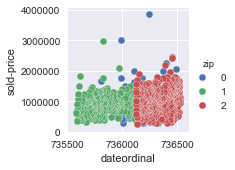

In [1031]:
sns.pairplot(data=df,hue='zip',
                  y_vars=['sold-price'],
                  x_vars=['bed','bath','sqft','type','year-built','lot',
                     'elementary-rate','middle-rate', 'high-rate',
                     'dateordinal'])

In [864]:
#Separate our features from our target
#X are the independent variables, y is the dependent variable
X=smaller_df.loc[:,['zip','bed','bath','sqft','type','year-built','lot',
                     'elementary-rate','middle-rate', 'high-rate',
                     'dateordinal','last street number']]

y=smaller_df['sold-price']

## Split the data into train and test sets
Have to put apartments from the same building in the same set

In [722]:
#cheking the occurences of the last digits of street number
#random number generator gave out 3 and 8 to be the test set
# import collections
# collections.Counter(smaller_df['last street number'])

Counter({0: 242,
         1: 187,
         2: 101,
         3: 109,
         4: 109,
         5: 167,
         6: 116,
         7: 141,
         8: 133,
         9: 85})

In [865]:
X_train=smaller_df[(smaller_df['last street number']!=5) & (smaller_df['last street number']!=8) &
                   (smaller_df['last street number']!=3)].loc[:,['zip','bed','bath',
                                                                 'sqft','type','year-built','lot',
                                                                 'elementary-rate','middle-rate', 'high-rate',
                                                                 'dateordinal']]
y_train=smaller_df[(smaller_df['last street number']!=5)& (smaller_df['last street number']!=8)&
                   (smaller_df['last street number']!=3)]['sold-price']
X_test=smaller_df[(smaller_df['last street number']==5)| (smaller_df['last street number']==8) |
                   (smaller_df['last street number']==3)].loc[:,['zip','bed','bath',
                                                                 'sqft','type','year-built','lot','elementary-rate',
                                                                 'middle-rate', 'high-rate','dateordinal']]
y_test=smaller_df[(smaller_df['last street number']==5)| (smaller_df['last street number']==8)|
                   (smaller_df['last street number']==3)]['sold-price']


In [866]:
len(X_train), len(y_train), len(X_test), len(y_test)


(981, 981, 409, 409)

In [581]:
# X_train=smaller_df[(smaller_df.zip==0) | (smaller_df.zip==2)].loc[:,['bed','bath','sqft','type','year-built','lot',
#                      'elementary-rate','middle-rate', 'high-rate',
#                      'dateordinal']]
# y_train=smaller_df[(smaller_df.zip==0) | (smaller_df.zip==2)]['sold-price']
# X_test=smaller_df[smaller_df.zip==1].loc[:,['bed','bath','sqft','type','year-built','lot',
#                      'elementary-rate','middle-rate', 'high-rate',
#                      'dateordinal']]
# y_test=smaller_df[smaller_df.zip==1]['sold-price']
# len(X_test),len(y_test),len(X_train),len(y_train)

(459, 459, 931, 931)

In [455]:
# Split the data 70-30 train/test
# use the train_test_split function from the sklearn, random_state will set the seed

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [1032]:

selected_columns_1 = ['zip','bed','bath','sqft','year-built','lot','elementary-rate',
                      'middle-rate', 'high-rate','dateordinal','type']

lr_model1 = LinearRegression()
lr_model1.fit(X_train.loc[:,selected_columns_1],y_train)
list(zip(selected_columns_1,lr_model1.coef_))

[('zip', 12904.979615445831),
 ('bed', 8086.6684516229552),
 ('bath', 19096.360458256193),
 ('sqft', 348.50534540801857),
 ('year-built', 386.76375926804269),
 ('lot', 27.469561475843033),
 ('elementary-rate', 11193.097404803015),
 ('middle-rate', 20364.67713556761),
 ('high-rate', 19564.962325903987),
 ('dateordinal', 301.38816900869904),
 ('type', 24863.025126484656)]

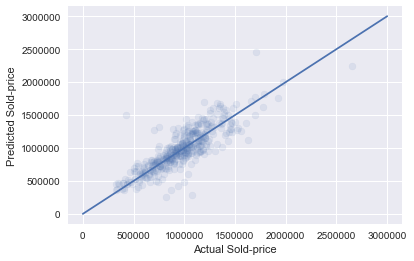

In [1000]:
#coefficients are from train data, then check the prediction with test dataset
test_set_pred1 = lr_model1.predict(X_test.loc[:,selected_columns_1])
plt.scatter(test_set_pred1,y_test,alpha=.1)
plt.plot(np.linspace(0,3000000,1000),np.linspace(0,3000000,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Predicted Sold-price')

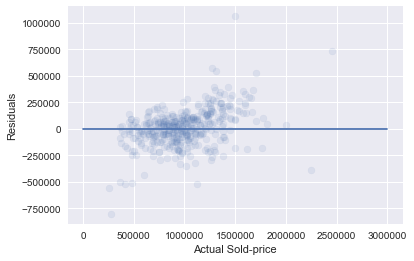

In [988]:
plt.scatter(y_test, y_test-test_set_pred1,alpha=.1)
plt.plot(np.linspace(0,3000000,1000),np.linspace(0,0,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Residuals')

In [870]:
lr_model1.score(X_test.loc[:,selected_columns_1],y_test)

0.69859534164357084

In [871]:
#RMSE
np.sqrt(np.mean((test_set_pred1 - y_test)**2))
# MAD
# (np.mean(np.abs(test_set_pred1 - y_test)))

177061.12389602861

In [872]:
smaller_df.describe()

,zip,bed,bath,sqft,type,year-built,lot,elementary-rate,middle-rate,high-rate,dateordinal,sold-price,last street number
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1.390000e+03,1390.000000
mean,1.007914,2.917266,2.002986,1468.795683,2.900000,1965.579137,4521.994964,6.209353,5.818705,7.726619,736185.846763,9.752294e+05,3.956115
std,0.818660,1.019425,0.754153,555.378158,1.673729,19.520213,3438.097435,2.275812,1.775425,0.948689,234.238442,3.439860e+05,2.965888
min,0.000000,0.000000,0.000000,440.000000,0.000000,1889.000000,0.000000,2.000000,3.000000,7.000000,735577.000000,2.600000e+05,0.000000
25%,0.000000,2.000000,1.500000,1089.000000,1.000000,1955.000000,871.000000,6.000000,5.000000,7.000000,736059.250000,7.431250e+05,1.000000
50%,1.000000,3.000000,2.000000,1387.500000,4.000000,1960.000000,5619.000000,6.000000,6.000000,7.000000,736227.000000,9.600000e+05,4.000000
75%,2.000000,3.000000,2.500000,1700.000000,4.000000,1976.000000,6669.250000,7.000000,6.000000,9.000000,736387.000000,1.179000e+06,7.000000
max,2.000000,9.000000,6.000000,7334.000000,5.000000,2016.000000,28749.000000,10.000000,10.000000,10.000000,736524.000000,3.875000e+06,9.000000


## Random Forest

In [1005]:
selected_columns_2 = ['bed','bath','sqft','year-built','lot','elementary-rate',
                       'dateordinal','type']


rfmodel1=RandomForestRegressor(n_estimators = 600, min_samples_leaf=1,  n_jobs=-1, max_features='sqrt') #Your parameters inside the parentheses
rfmodel1.fit(X_train.loc[:,selected_columns_2],y_train)
rf1_test_pred = rfmodel1.predict(X_test.loc[:,selected_columns_2])

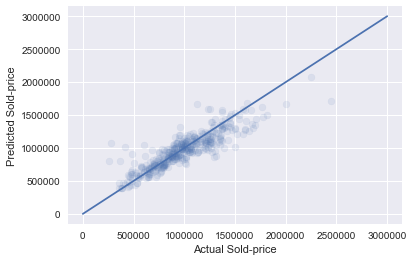

In [1006]:
#Plot actual vs predicted
plt.scatter(y_test, rf1_test_pred,alpha=.1)
plt.plot(np.linspace(0,3000000,1000),np.linspace(0,3000000,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Predicted Sold-price')


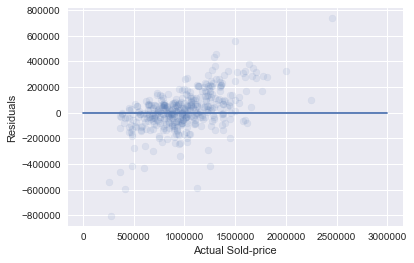

In [985]:
plt.scatter(y_test, y_test-rf1_test_pred,alpha=.1)
plt.plot(np.linspace(0,3000000,1000),np.linspace(0,0,1000))
plt.xlabel('Actual Sold-price')
plt.ylabel('Residuals')

In [1007]:
rfmodel1.score(X_test.loc[:,selected_columns_2],y_test)

0.76745615636259301

In [1004]:
sorted(list(zip(X_train.loc[:,selected_columns_2].columns,rfmodel1.feature_importances_)), key=lambda x: x[1], reverse=True)

[('sqft', 0.31410987256657147),
 ('lot', 0.15098477171676788),
 ('type', 0.12131053793649317),
 ('bed', 0.10454088212122405),
 ('year-built', 0.081398992810727766),
 ('dateordinal', 0.074009406296608862),
 ('elementary-rate', 0.069918538610933556),
 ('bath', 0.044056480404961761),
 ('middle-rate', 0.039670517535711866)]

## Random permutation of the feature variables to check for whether the features are random noise
## Keep all other features fixed, check the feature on the bottom of importance

In [877]:
import random
df.describe()

,zip,bed,bath,sqft,type,year-built,lot,sold-price,elementary-rate,middle-rate,high-rate,dateordinal,last street number
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1.390000e+03,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000
mean,1.007914,2.917266,2.002986,1468.795683,2.900000,1965.579137,4521.994964,9.752294e+05,6.209353,5.818705,7.726619,736185.846763,3.956115
std,0.818660,1.019425,0.754153,555.378158,1.673729,19.520213,3438.097435,3.439860e+05,2.275812,1.775425,0.948689,234.238442,2.965888
min,0.000000,0.000000,0.000000,440.000000,0.000000,1889.000000,0.000000,2.600000e+05,2.000000,3.000000,7.000000,735577.000000,0.000000
25%,0.000000,2.000000,1.500000,1089.000000,1.000000,1955.000000,871.000000,7.431250e+05,6.000000,5.000000,7.000000,736059.250000,1.000000
50%,1.000000,3.000000,2.000000,1387.500000,4.000000,1960.000000,5619.000000,9.600000e+05,6.000000,6.000000,7.000000,736227.000000,4.000000
75%,2.000000,3.000000,2.500000,1700.000000,4.000000,1976.000000,6669.250000,1.179000e+06,7.000000,6.000000,9.000000,736387.000000,7.000000
max,2.000000,9.000000,6.000000,7334.000000,5.000000,2016.000000,28749.000000,3.875000e+06,10.000000,10.000000,10.000000,736524.000000,9.000000


In [878]:
df_random=pd.DataFrame()
df_random['sold-price']=df['sold-price']
for i in selected_columns_1:
    #df_random[i]=np.random.choice(np.arange(min(df[i]),max(df[i])+1),len(df))
    df_random[i]=np.random.randint(min(df[i]),max(df[i])+1,len(df))

In [879]:
df_random.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1390 entries, 1 to 1487
Data columns (total 12 columns):
sold-price         1390 non-null int64
zip                1390 non-null int64
bed                1390 non-null int64
bath               1390 non-null int64
sqft               1390 non-null int64
year-built         1390 non-null int64
lot                1390 non-null int64
elementary-rate    1390 non-null int64
middle-rate        1390 non-null int64
high-rate          1390 non-null int64
dateordinal        1390 non-null int64
type               1390 non-null int64
dtypes: int64(12)
memory usage: 141.2 KB


In [880]:
XR=df.loc[:,['bed','bath','sqft','type','year-built','lot',
                     'elementary-rate','middle-rate','high-rate',
                     'dateordinal','sold-price']]
XR['zipR']=df_random['zip']
#yR=df['sold-price']
#X_trainR, X_testR, y_trainR, y_testR = train_test_split(XR, yR, test_size=0.3,random_state=42)
X_trainR=XR[(smaller_df['last street number']!=5) & (smaller_df['last street number']!=8) &
                   (smaller_df['last street number']!=3)].loc[:,['zipR','bed','bath',
                                                                 'sqft','type','year-built','lot',
                                                                 'elementary-rate','middle-rate', 'high-rate',
                                                                 'dateordinal']]
y_trainR=XR[(smaller_df['last street number']!=5)& (smaller_df['last street number']!=8)&
                   (smaller_df['last street number']!=3)]['sold-price']
X_testR=XR[(smaller_df['last street number']==5)| (smaller_df['last street number']==8) |
                   (smaller_df['last street number']==3)].loc[:,['zipR','bed','bath',
                                                                 'sqft','type','year-built','lot','elementary-rate',
                                                                 'middle-rate', 'high-rate','dateordinal']]
y_testR=XR[(smaller_df['last street number']==5)| (smaller_df['last street number']==8)|
                   (smaller_df['last street number']==3)]['sold-price']


In [881]:
X_trainR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 3 to 1487
Data columns (total 11 columns):
zipR               981 non-null int64
bed                981 non-null int64
bath               981 non-null float64
sqft               981 non-null float64
type               981 non-null int64
year-built         981 non-null float64
lot                981 non-null int64
elementary-rate    981 non-null int64
middle-rate        981 non-null int64
high-rate          981 non-null int64
dateordinal        981 non-null int64
dtypes: float64(3), int64(8)
memory usage: 92.0 KB


In [972]:
rfmodel_R=RandomForestRegressor(n_estimators = 600, min_samples_leaf=1,  n_jobs=-1, max_features='sqrt') #Your parameters inside the parentheses
rfmodel_R.fit(X_trainR,y_trainR)
rfR_test_pred = rfmodel_R.predict(X_testR)

In [971]:
rfmodel_R.score(X_testR,y_testR)

0.76672106451810129

In [883]:
sorted(list(zip(X_trainR.columns,rfmodel_R.feature_importances_)), 
       key=lambda x: x[1], reverse=True),sorted(list(zip(X_train.loc[:,selected_columns_2].columns,rfmodel1.
                            feature_importances_)), key=lambda x: x[1], reverse=True)



([('sqft', 0.28368364906249821),
  ('lot', 0.15857687122757425),
  ('type', 0.10979602024592085),
  ('bed', 0.10402129593435246),
  ('year-built', 0.0887820521325203),
  ('dateordinal', 0.068909278275031863),
  ('elementary-rate', 0.062694830052486508),
  ('bath', 0.051908437550115261),
  ('middle-rate', 0.030441861876049046),
  ('high-rate', 0.027734893961000175),
  ('zipR', 0.013450809682451279)],
 [('sqft', 0.28734968817625645),
  ('lot', 0.14635994253667808),
  ('type', 0.11429006247899028),
  ('bed', 0.1116963636820653),
  ('year-built', 0.089662585321122243),
  ('dateordinal', 0.068128126205442244),
  ('elementary-rate', 0.061684044449616865),
  ('bath', 0.049089068246875124),
  ('middle-rate', 0.030015341902826974),
  ('high-rate', 0.027953190524714594),
  ('zip', 0.013771586475411955)])

## Trying out all regressions, only as guidelines

In [1008]:
#X,holdoutX,y,holdouty = model_selection.train_test_split(X,y,test_size = .3)
X=smaller_df[(smaller_df['last street number']!=5) & (smaller_df['last street number']!=8) &
                   (smaller_df['last street number']!=3)].loc[:,['zip','bed','bath',
                                                                 'sqft','type','year-built','lot',
                                                                 'elementary-rate','middle-rate', 'high-rate',
                                                                 'dateordinal']]
y=smaller_df[(smaller_df['last street number']!=5)& (smaller_df['last street number']!=8)&
                   (smaller_df['last street number']!=3)]['sold-price']
holdoutX=smaller_df[(smaller_df['last street number']==5)| (smaller_df['last street number']==8) |
                   (smaller_df['last street number']==3)].loc[:,['zip','bed','bath',
                                                                 'sqft','type','year-built','lot','elementary-rate',
                                                                 'middle-rate', 'high-rate','dateordinal']]
holdouty=smaller_df[(smaller_df['last street number']==5)| (smaller_df['last street number']==8)|
                   (smaller_df['last street number']==3)]['sold-price']


# X=smaller_df[(smaller_df.zip==0) | (smaller_df.zip==2)].loc[:,['zip','bed','bath','sqft','type','year-built','lot',
#                      'elementary-rate','middle-rate', 'high-rate',
#                      'dateordinal']]
# y=smaller_df[(smaller_df.zip==0) | (smaller_df.zip==2)]['sold-price']
# holdoutX=smaller_df[smaller_df.zip==1].loc[:,['bed','bath','sqft','type','year-built','lot',
#                      'elementary-rate','middle-rate', 'high-rate',
#                      'dateordinal']]
# holdouty=smaller_df[smaller_df.zip==1]['sold-price']

models = {}
parameters = {}

models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=.5)
models['robust_regression'] = linear_model.SGDRegressor(loss='huber',n_iter=20)
models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',n_iter=20)


models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = model_selection.cross_val_score(model, X, y, n_jobs=1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()


Model: linear_model
Score: 0.512944257193

Model: ridge_model
Score: 0.51361651472

Model: lasso_model
Score: 0.512951568242

Model: robust_regression
Score: -2.72092244183

Model: eps_insensitive
Score: -59.0203547058

Model: cart
Score: 0.554195443439

Model: extratrees
Score: 0.399145250374

Model: randomForest
Score: 0.607061243202

Model: adaboostedTrees
Score: 0.504287187289

Model: gradboostedTrees
Score: 0.65793806586



## Gradient Boosting

In [884]:
from sklearn.ensemble import GradientBoostingRegressor

In [1013]:
gbmodel1=GradientBoostingRegressor(max_features=5,min_samples_leaf=1,
                                   max_depth=2, n_estimators=110)
gbmodel1.fit(X,y)
gb1_test_pred = gbmodel1.predict(holdoutX)
gbmodel1.score(holdoutX,holdouty)

0.7458089271352506

In [1010]:
sorted(list(zip(X.columns,gbmodel1.feature_importances_)), 
       key=lambda x: x[1], reverse=True)


[('sqft', 0.28033540894392334),
 ('dateordinal', 0.18023761583252898),
 ('lot', 0.17735352179669017),
 ('year-built', 0.12695525153987325),
 ('elementary-rate', 0.075234479677564373),
 ('bath', 0.045358177781064754),
 ('zip', 0.036546227870314592),
 ('bed', 0.031755398992143545),
 ('type', 0.028638381605034333),
 ('middle-rate', 0.017585535960862691)]

## checking overfit of parameters


In [791]:
#keep everything fixed and try a bunch of different values and plot
#param_ranges is the hyperparameter and the range to try the parameters over
def plot_overfit(X,y,model_obj,param_ranges,param_static=None): 
    for parameter,parameter_range in param_ranges.items():
        avg_train_score, avg_test_score = [],[]
        std_train_score, std_test_score = [],[]
        
        for param_val in parameter_range:
            param = {parameter:param_val}
            if param_static:
                param.update(param_static)
            
                
            model = model_obj(**param)
            
            train_scores,test_scores = [],[]
            for i in range(10):
                X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size = .3)
                model.fit(X_train,y_train)
                
                train_scores.append(model.score(X_train,y_train))
                test_scores.append(model.score(X_test,y_test))
            
            avg_train_score.append(np.mean(train_scores))
            avg_test_score.append(np.mean(test_scores))
            
            std_train_score.append(np.std(train_scores))
            std_test_score.append(np.std(test_scores))
            
        fig,ax = plt.subplots()
        ax.errorbar(parameter_range,avg_train_score,yerr=std_train_score,label='training score')
        ax.errorbar(parameter_range,avg_test_score,yerr=std_test_score,label='testing score')
        
        ax.set_xlabel(parameter)
        ax.set_ylabel('score')
        ax.legend(loc=0)

(None, None, None)

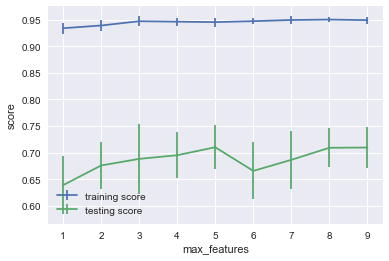

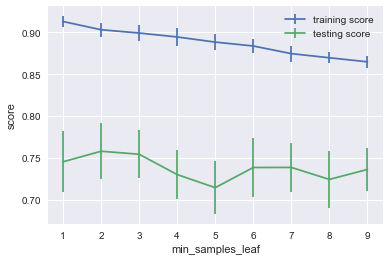

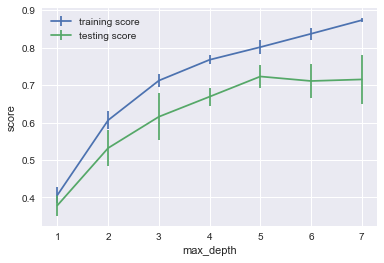

In [975]:
plot_overfit(X,y,RandomForestRegressor,{'max_features':range(1,10)}), plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'min_samples_leaf':range(1,10)}),\
plot_overfit(X,y,RandomForestRegressor,{'max_depth':range(1,8)})


In [976]:
# plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'max_features':range(1,10)}), plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'min_samples_leaf':range(1,10)}),\
# plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'max_depth':range(1,8)})


(None, None)

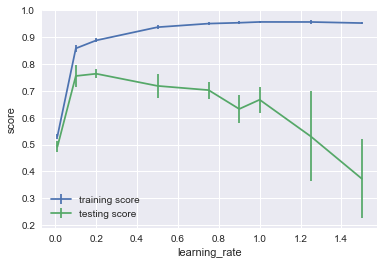

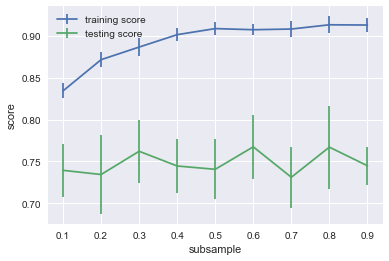

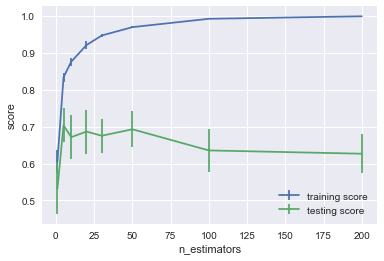

In [838]:
model = ensemble.GradientBoostingRegressor
params = {'learning_rate':[.01,.1,.2,.5,.75,.9,1,1.25,1.5]}
param_static = {'max_depth':2}
plot_overfit(X,y,model,params,param_static=param_static)
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'subsample':np.arange(.1,1,.1)}),\
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'n_estimators':[1,5,10,20,30,50,100,200]},param_static={'learning_rate':.75})


(None, None)

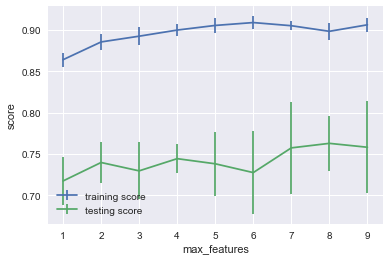

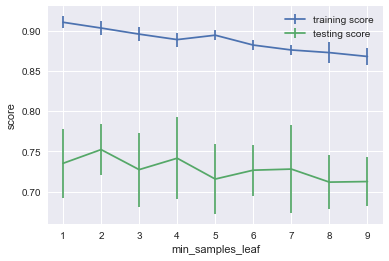

In [835]:
#testing max_features
#max_features=5
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'max_features':range(1,10)})

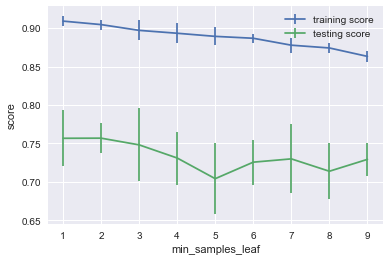

In [795]:
#testing min_samples_leaf
#min_sample_leaf=1
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'min_samples_leaf':range(1,10)})

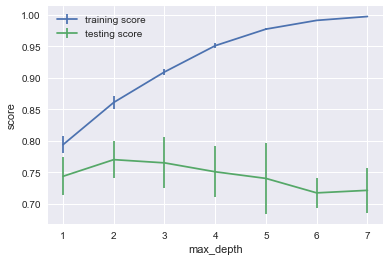

In [796]:
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'max_depth':range(1,8)})
#max depth=2

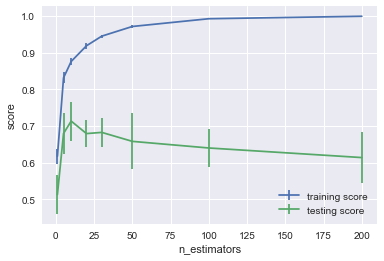

In [802]:
#n_estimators=110 which isn't quite consistent with the graph, but have to consider other features
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'n_estimators':[1,5,10,20,30,50,100,200]},param_static={'learning_rate':.75})


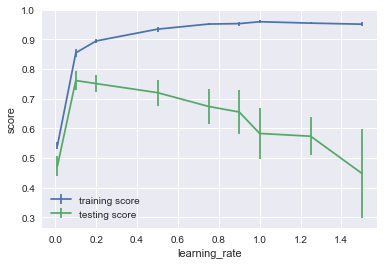

In [817]:
#test learning rates with max_depth fixed
#learning-rate=0.1
model = ensemble.GradientBoostingRegressor
params = {'learning_rate':[.01,.1,.2,.5,.75,.9,1,1.25,1.5]}
param_static = {'max_depth':2}
plot_overfit(X,y,model,params,param_static=param_static)

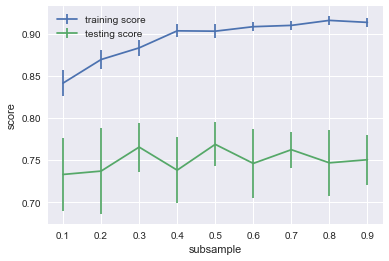

In [823]:
#doesn't matter much
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'subsample':np.arange(.1,1,.1)})

In [654]:
from sklearn.model_selection import GridSearchCV

In [824]:
parameters = {'max_depth':[2,3],
              'learning_rate':np.arange(.01,.1,.01),
              'n_estimators':[20,50,100,200],
             'min_samples_leaf':[1,2]}

model = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(model, parameters, n_jobs=-2, verbose=1)
grid_search.fit(X_train,y_train)
grid_search.best_estimator_



Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-2)]: Done 386 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-2)]: Done 432 out of 432 | elapsed:    8.0s finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.089999999999999997, loss='ls', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=2,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

## Cross validation Lasso

In [ ]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
selected_columns_2 = ['bed','bath','sqft','year-built','rate1','rate2','rate3','type','dateordinal']


In [1015]:
#cross validation
alphavec = 10**np.linspace(-3,9,27)
alphavec


array([  1.00000000e-03,   2.89426612e-03,   8.37677640e-03,
         2.42446202e-02,   7.01703829e-02,   2.03091762e-01,
         5.87801607e-01,   1.70125428e+00,   4.92388263e+00,
         1.42510267e+01,   4.12462638e+01,   1.19377664e+02,
         3.45510729e+02,   1.00000000e+03,   2.89426612e+03,
         8.37677640e+03,   2.42446202e+04,   7.01703829e+04,
         2.03091762e+05,   5.87801607e+05,   1.70125428e+06,
         4.92388263e+06,   1.42510267e+07,   4.12462638e+07,
         1.19377664e+08,   3.45510729e+08,   1.00000000e+09])

In [1016]:
lr_model3 = LassoCV(alphas = alphavec, cv=5)
lr_model3.fit(X_train.loc[:,selected_columns_2],y_train)


LassoCV(alphas=array([  1.00000e-03,   2.89427e-03,   8.37678e-03,   2.42446e-02,
         7.01704e-02,   2.03092e-01,   5.87802e-01,   1.70125e+00,
         4.92388e+00,   1.42510e+01,   4.12463e+01,   1.19378e+02,
         3.45511e+02,   1.00000e+03,   2.89427e+03,   8.37678e+03,
         2.42446e+04,   7.01704e+04,   2.03092e+05,   5.87802e+05,
         1.70125e+06,   4.92388e+06,   1.42510e+07,   4.12463e+07,
         1.19378e+08,   3.45511e+08,   1.00000e+09]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [1017]:
lr_model3.alpha_

8376.7764006829238

In [577]:
list(zip(X_train.columns,lr_model3.coef_))

[('bed', 72943.569108566386),
 ('bath', 0.0),
 ('sqft', 411.0733294279766),
 ('year-built', -1649.8195508981216),
 ('lot', 3065.9179927368687),
 ('rate1', 33649.733183351782),
 ('rate2', 43052.358126672902),
 ('rate3', 312.99922693989691)]

In [1018]:
test_set_pred3 = lr_model3.predict(X_test.loc[:,selected_columns_2])
#RMSE
np.sqrt(np.mean((test_set_pred3 - y_test)**2))
#R-square
lr_model3.score(X_test.loc[:,selected_columns_2],y_test)

0.66314894923419399

In [ ]:
# #create dummies for house type
# df['apartment']=pd.get_dummies(df.type)['Apartment'].values
# df['condo']=pd.get_dummies(df.type)['Condo'].values
# df['multifamily']=pd.get_dummies(df.type)['Multi Family'].values
# df['multioccupancy']=pd.get_dummies(df.type)['Multiple Occupancy'].values
# df['singlefamily']=pd.get_dummies(df.type)['Single Family'].values
# df['townhouse']=pd.get_dummies(df.type)['Townhouse'].values


In [1022]:
df.high.unique()

array(['Santa Clara High', 'Del Mar High', 'Adrian Wilcox High',
       'Abraham Lincoln High', 'Cupertino High', 'Prospect High',
       'Westmont High'], dtype=object)

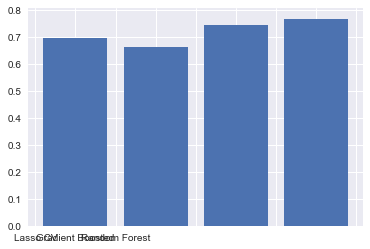

In [1044]:
r=[['OLS','Lasso CV','Gradient Boosted','Random Forest'],[0.697,0.663,0.745,0.767]]
fig, ax = plt.subplots()
ax.bar(left=[1,2,3,4],height=r[1])
ax.set_xticklabels(r[0])